In [70]:
import pandas as pd
import numpy as np
import seaborn as sns

In [71]:
df = pd.read_csv('F1_Q3_2024.csv')
df = df.dropna()
print(df.shape)
df.head()

(428, 19)


,Date,Name of Race,Name of Track,Driver Name,Team,Teammate in Q3,Attempted Hot Lap Number (1 or 2),Time Remaining in Session at start of Outlap (Seconds),Number of Outlaps,Amount of Drivers on Track at start of Hot Lap,Track Temperature at start of Hotlap,Weather at start of Hot Lap,Tire type during hot lap,Sector 1 Time,Sector 2 Time,Sector 3 Time,Length of Hotlap Attempt,Position after Lap,Position after Session End
0,20240301,Gulf Air Bahrain Grand Prix,Bahrain International Circuit,VERSTAPPEN,Red Bull,Y,1,678,1,8,21.0,Clear,S,28.686,38.361,22.374,89.421,1,1
1,20240301,Gulf Air Bahrain Grand Prix,Bahrain International Circuit,VERSTAPPEN,Red Bull,Y,2,162,1,8,21.0,Clear,S,28.535,38.269,22.375,89.179,1,1
2,20240301,Gulf Air Bahrain Grand Prix,Bahrain International Circuit,LECLERC,Ferrari,Y,1,641,1,8,21.1,Clear,S,28.863,38.344,22.273,89.480,2,2
3,20240301,Gulf Air Bahrain Grand Prix,Bahrain International Circuit,LECLERC,Ferrari,Y,2,151,1,8,21.0,Clear,S,28.762,38.276,22.369,89.407,2,2
4,20240301,Gulf Air Bahrain Grand Prix,Bahrain International Circuit,RUSSELL,Mercedes,Y,1,687,1,8,21.0,Clear,S,28.800,38.503,22.300,89.603,1,3


In [72]:
# Reduce column name length (makes them easier to work with)
abbv = ['DATE', 'RACE', 'TRACK', 'DRIVER', 'TEAM', 'TEAMMATE', 'HOTLAP_ATT', 'OUTLAP_START', 'NUM_OUTLAPS', 'TRAFFIC', 'TRACK_TEMP', 'WEATHER', 'TIRE', 'S1_TIME', 'S2_TIME', 'S3_TIME', 'TOTAL_TIME', 'POS_TEMP', 'POS_FINAL']
df.columns = abbv

In [73]:
# Sort data first by date of the session, then by driver name
df = df.sort_values(by=['DATE', 'DRIVER'])

In [74]:
# For each session, and for each driver, count number of hotlaps completed
hotlaps = df.groupby(['DATE', 'DRIVER']).HOTLAP_ATT.count()

# Create a series to indicate session-driver pairings where 2 hotlaps were completed
multi_hotlap = hotlaps[hotlaps == 2].index

# Filter data to contain only samples involved in a 2 hotlap session
multi_hotlap_df = df[df[['DATE', 'DRIVER']].apply(tuple, axis=1).isin(multi_hotlap.tolist())]
multi_hotlap_df.shape[0]

370

In [75]:
# Check how many HOTLAP_ATT values are 1 or 2
multi_hotlap_df["HOTLAP_ATT"].value_counts().sort_index()

HOTLAP_ATT
1    185
2    185
Name: count, dtype: int64

In [76]:
from scipy.stats import ttest_rel

In [77]:
# Test whether attempting a 2nd hotlap yields a significant improvement in lap time

lap_one_times = multi_hotlap_df[(multi_hotlap_df.HOTLAP_ATT == 1)].TOTAL_TIME
lap_two_times = multi_hotlap_df[(multi_hotlap_df.HOTLAP_ATT == 2)].TOTAL_TIME

# H_0: There is no difference in average time for the first hotlap attempt and second hotlap attempt. L2-L1 = 0
# H_1: There is a difference in average time for the first hotlap attempt and second hotlap attempt. L2-L1 != 0

result = ttest_rel(lap_two_times, lap_one_times, alternative='two-sided')
print('T-stat:', result.statistic)
print('p-value:', result.pvalue)
ci_95 = result.confidence_interval(confidence_level=0.95)
print(f"95% CI: [{ci_95.low}, {ci_95.high:}]")

T-stat: -9.109162784527106
p-value: 1.3974446576256044e-16
95% CI: [-0.41605356251379305, -0.2679140050537759]


In [78]:
# H_0: The second hotlap attempt is on average not faster than the first hotlap attempt. L2-L1 >= 0
# H_1: The second hotlap attempt is on average faster than the first hotlap attempt. L2-L1 < 0

result = ttest_rel(lap_two_times, lap_one_times, alternative='less')
print('T-stat:', result.statistic)
print('p-value:', result.pvalue)
ci_95 = result.confidence_interval(confidence_level=0.95)
print(f"95% One-Sided CI: [<{ci_95.high:}]")

T-stat: -9.109162784527106
p-value: 6.987223288128022e-17
95% One-Sided CI: [<-0.2799188312704168]


In [79]:
# Create a series to indicate session-driver pairings where only 1 hotlap was completed
one_hotlap = hotlaps[hotlaps == 1].index

# Filter data to contain only samples involved in a 1 hotlap session
one_hotlap_df = df[df[['DATE', 'DRIVER']].apply(tuple, axis=1).isin(one_hotlap.tolist())]
one_hotlap_df.shape[0]

46

In [80]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

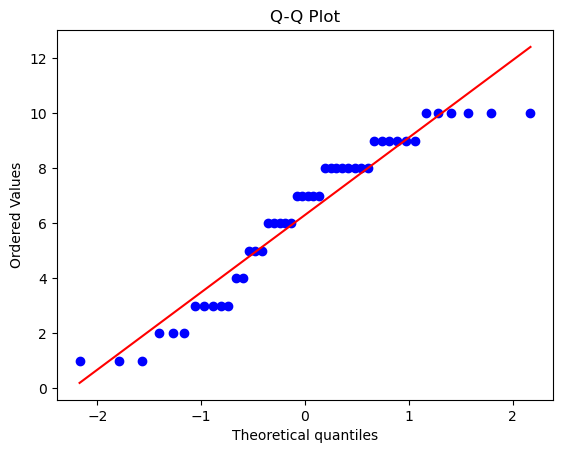

In [81]:
# Q-Q plot to check normality of grid position distribution for 1 hotlap sessions
data = one_hotlap_df.POS_FINAL
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

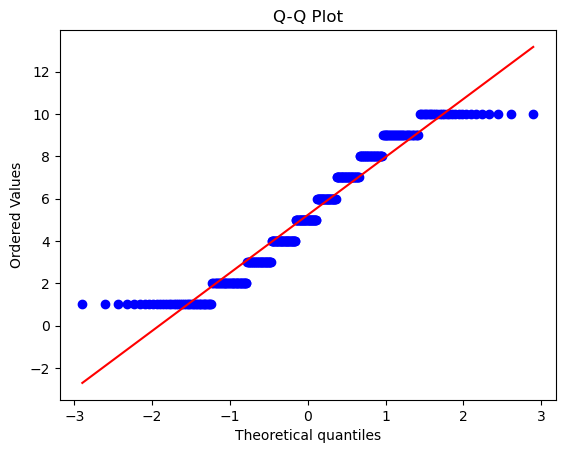

In [82]:
# Q-Q plot to check normality of grid position distribution for 2 hotlap sessions
data = multi_hotlap_df.POS_FINAL
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In [83]:
from scipy.stats import levene

In [84]:
# Implement Levene's Test to evaluate equality of variances

one_lap_positions = one_hotlap_df.POS_FINAL
two_lap_positions = multi_hotlap_df.drop_duplicates(['DATE', 'POS_FINAL']).POS_FINAL

result = levene(one_lap_positions, two_lap_positions)
print('T-stat:', result.statistic)
print('p-value:', result.pvalue)

T-stat: 0.02711006050433892
p-value: 0.8693636705502706


In [85]:
from scipy.stats import ttest_ind

In [86]:
# Test whether drivers attempting 2 hotlaps (as opposed to 1) qualify for better grid position
# Smaller grid position = better

# H_0: On average, grid position for drivers who attempt 1 hotlap in Q3 is no worse than grid position 
# for drivers attempting 2 hotlaps in Q3
# H_1: On average, grid position for drivers who attempt 1 hotlap in Q3 is worse than grid position
# for drivers attempting 2 hotlaps in Q3

result = ttest_ind(one_lap_positions, two_lap_positions, equal_var=True, alternative='greater')
print('T-stat:', result.statistic)
print('p-value:', result.pvalue)
ci_95 = result.confidence_interval(confidence_level=0.95)
print(f"95% One-Sided CI: [>{ci_95.low:}]")

T-stat: 2.3257220813370645
p-value: 0.0104539425652641
95% One-Sided CI: [>0.31229697713522786]
